# Decision Tree

## Getting Started

Start by loading two binary classification datasets - the spiral dataset and the <a href="https://archive.ics.uci.edu/ml/datasets/Ionosphere">ION</a> dataset.

In [1]:
import pandas as pd
import numpy as np
from numpy.matlib import repmat
import matplotlib.pyplot as plt

The code below generates spiral data using the trigonometric functions sine and cosine, then splits the data into train and test segments.

In [2]:
def spiraldata(N=300):
    # generate a vector of "radius" values
    r = np.linspace(1,2*np.pi,N)
    
    # generate a curve that draws circles with increasing radius
    X_train1 = np.array([np.sin(2 * r) * r, np.cos(2 * r) * r]).T
    X_train2 = np.array([np.sin(2 * r + np.pi) * r, np.cos(2 * r + np.pi) * r]).T
    X_train  = np.concatenate([X_train1, X_train2], axis=0)
    y_train  = np.concatenate([np.ones(N), -1 * np.ones(N)])
    X_train  = X_train + np.random.randn(X_train.shape[0], X_train.shape[1]) * 0.2
    
    # Now sample alternating values to generate the test and train sets
    X_test  = X_train[::2,:]
    y_test  = y_train[::2]
    X_train = X_train[1::2,:]
    y_train = y_train[1::2]
    
    return X_train, y_train, X_test, y_test

We can plot xTrSpiral to see the curve generated by the function above:

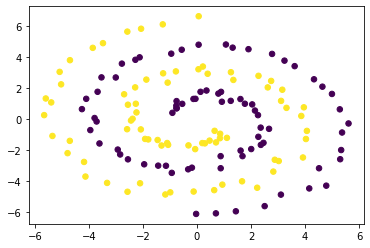

In [3]:
xTrSpiral, yTrSpiral, xTeSpiral, yTeSpiral = spiraldata(150)
plt.scatter(xTrSpiral[:,0], xTrSpiral[:,1], 30, yTrSpiral)
plt.show()

The following code loads the ION dataset.

In [4]:
# load in some binary test data (labels are -1, +1)
data = pd.read_csv('../data/ion.csv', header=None)
print(data.head())

# Load the features and labels
X = data.drop(34, axis=1).values
y = data.loc[:,34].values

# Create train and test data
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
print(set(y))
le.fit(list(set(y)))
y = le.transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,...,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,g
1,1,0,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,...,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,b
2,1,0,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,...,-0.40220,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238,g
3,1,0,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,...,0.90695,0.51613,1.00000,1.00000,-0.20099,0.25682,1.00000,-0.32382,1.00000,b
4,1,0,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,-0.16399,...,-0.65158,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697,g


{'b', 'g'}


<h2>Implement Regression Trees</h2>

<h3>Part One: Implement <code>sqimpurity</code></h3>

<p>First, we implement the function <code>sqimpurity</code> which takes as input a vector of $n$ labels and outputs the corresponding squared loss impurity
$$\sum_{i} (y_i-\bar{y}_i)^2 \textrm{ where: } \bar{y}_i=\frac{1}{n}\sum_{i} y_i$$
</p>

In [5]:
def sqimpurity(y_train):
    """This function computes the weighted variance of the labels."""
    N, = y_train.shape
    assert N > 0 # must have at least one sample
    
    # compute the mean
    ybar = np.mean(y_train)
    impurity = np.sum(np.power(y_train - ybar, 2))
    
    return impurity

<h3>Part Two: Implement <code>sqsplit</code></h3>

<p>Now we implement <code>sqsplit</code>, which takes as input a data set with labels and computes the best feature and cut-value of an optimal split based on the squared error impurity. The <code>sqsplit</code> function takes as input a data set of row vectors and a label vector and outputs a feature dimension, a cut threshold, and the impurity loss of this best split. The cut value should be the average of the values in the dimension where two datapoints are split. To find the best split, evaluate all possible splits and then search for the split that yields the minimum loss.</p>

<p>Remember that we evaluate the quality of a split of a parent set $S_P$ into two sets $S_L$ and $S_R$ by the weighted impurity of the two branches, i.e.</p>

$\frac{\left|S_L\right|}{\left|S_P\right|}I\left(S_L\right)+\frac{\left|S_R\right|}{\left|S_P\right|}I\left(S_R\right)$

<p>In the case of the squared loss, this becomes:</p>

$\frac{1}{|S_P|}\sum_{(x,y)\in S_L}(y-\bar{y}_{S_L})^2 +\frac{1}{|S_P|}\sum_{(x,y)\in S_R}(y-\bar{y}_{S_R})^2$

<em>Note: Avoid splitting on datapoints with same value in a dimension.</em>

In [6]:
def sqsplit(X_train, y_train):
    """This function finds the best feature, cut value, and loss value."""
    N, D = X_train.shape
    assert D > 0 # must have at least one dimension
    assert N > 1 # must have at least two samples
    
    # initialize return values
    bestloss = np.inf
    feature = np.inf
    cut = np.inf
    
    # iterate over values
    for d in range(D):
        # sort the arrays
        x = X_train[:,d].flatten()
        idx = np.argsort(x)
        x = x[idx]
        y = y_train[idx]
        
        for k in range(0,len(y)-1):
            if x[k] == x[k+1]:
                continue
            left = y[:k+1]
            right = y[k+1:]
            
            loss = sqimpurity(left) + sqimpurity(right)
            if loss < bestloss:
                bestloss = loss
                feature = d
                cut = np.mean([x[k], x[k+1]])
                
    return feature, cut, bestloss

<h3>Part Three: Implement <code>cart</code></h3>

In this section, we implement the function <code>cart</code>, which returns a regression tree based on the minimum squared loss splitting rule. We use the function <code>sqsplit</code> to make splits. <p>The <code>TreeNode</code> class below represents our tree. Note that the nature of CART trees implies that every node has exactly 0 or 2 children.</p>

<h4>Tree Structure</h4>

<p>The tree structure comes with distinct leaves and nodes. Leaves have two fields, parent (another node) and prediction (a numerical value).</p>

<strong>Nodes have six fields:</strong>
<ol>
    <li> <b>left</b>: node describing left subtree </li>
    <li> <b>right</b>: node describing right subtree </li>
    <li> <b>feature</b>: index of feature to cut </li>
    <li> <b>cut</b>: cutoff value c (<= c : left, and > c : right)</li>
    <li> <b>prediction</b>: prediction at this node (This should be the average of the labels at this node)</li>
</ol>

In [7]:
class TreeNode(object):
    def __init__(self, left, right, feature, cut, prediction):
        self.left = left
        self.right = right
        self.feature = feature
        self.cut = cut
        self.prediction = prediction

In [8]:
def cart(X_train, y_train):
    """This function builds a CART tree."""
    n,d = X_train.shape
    
    # initialize
    prediction = np.mean(y_train)
    x_u = len(set(X_train.reshape(-1)))
    y_u = len(np.unique(y_train))
    
    if x_u == 1 or y_u == 1:
        tree = TreeNode(None, None, None, None, prediction)
    else:
        feature, cut, bestloss = sqsplit(X_train, y_train)
        if feature == np.inf or cut == np.inf or bestloss == np.inf:
            tree = TreeNode(None, None, None, None, prediction)
            return tree
        
        # generate left and right branch
        X_train_l = X_train[X_train[:,feature] <= cut,:]
        X_train_r = X_train[X_train[:,feature] > cut,:]
        y_train_l = y_train[X_train[:,feature] <= cut]
        y_train_r = y_train[X_train[:,feature] > cut]
        
        tree = TreeNode(None, None, feature, cut, prediction)
        tree.left = cart(X_train_l, y_train_l)
        tree.right = cart(X_train_r, y_train_r)
        tree.right.parent = tree
        tree.left.parent = tree
    
    return tree

<h3>Part Four: Implement <code>evaltree</code></h3>

<p>Implement the function <code>evaltree</code>, which evaluates a decision tree on a given test data set.</p>

In [9]:
def evaltree(root, X_test):
    """This function evaluates X_test using a decision tree root."""
    # initialize and iterate
    n,d = X_test.shape
    pred = np.zeros(n)
    for i in range(n):
        r = root
        x = X_test[i,:].flatten()
        while r.left is not None and r.right is not None:
            feature = r.feature
            cut = r.cut
            if x[feature] <= cut:
                r = r.left
            else:
                r = r.right
        else:
            pred[i] = r.prediction
            
    return pred

<h3>Visualize Tree</h3>

<p>The following code defines a function <code>visclassifier()</code>, which plots the decision boundary of a classifier in 2 dimensions. Execute the following code to see what the decision boundary of your tree looks like on the ion data set.</p>

In [10]:
def visclassifier(fun, X_train, y_train, w=None, b=0):
    y_train = np.array(y_train).flatten()
    symbols = ['ko', 'kx']
    marker_symbols = ['o', 'x']
    mycolors = [[0.5, 0.5, 1], [1, 0.5, 0.5]]
    
    # get the unique values from labels array
    classvals = np.unique(y_train)
    
    plt.figure()
    
    # return 300 evenly spaced numbers over this interval
    res = 300
    xrange = np.linspace(min(X_train[:, 0]), max(X_train[:, 0]), res)
    yrange = np.linspace(min(X_train[:, 1]), max(X_train[:, 1]), res)
    
    # repeat this matrix 300 times for both axes
    pixelX = repmat(xrange, res, 1)
    pixelY = repmat(yrange, res, 1).T
    
    X_test = np.array([pixelX.flatten(), pixelY.flatten()]).T
    
    # test all of these points on the grid
    testpreds = fun(X_test)
    
    # reshape it back together to make our grid
    Z = testpreds.reshape(res, res)
    # Z[0,0] = 1 # optional: scale the colors correctly
    
    # fill in the contours for these predictions
    plt.contourf(pixelX, pixelY, np.sign(Z), colors=mycolors)
    
    # creates x's and o's for training set
    for idx, c in enumerate(classvals):
        plt.scatter(X_train[y_train == c,0], X_train[y_train == c,1], marker=marker_symbols[idx], color='k')
    
    if w is not None:
        w = np.array(w).flatten()
        alpha = -1 * b / (w ** 2).sum()
        plt.quiver(w[0] * alpha, w[1] * alpha, w[0], w[1], linewidth=2, color=[0,1,0])
        
    plt.axis('tight')
    plt.show()

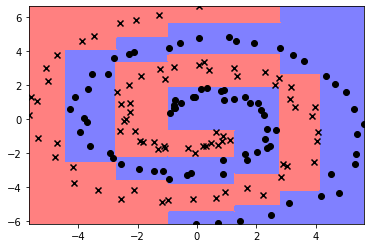

Training error: 0.0000
Testing error:  0.0400


In [11]:
tree = cart(xTrSpiral, yTrSpiral) # compute tree on training data
visclassifier(lambda X: evaltree(tree,X), xTrSpiral, yTrSpiral)

print('Training error: %.4f' % np.mean(np.sign(evaltree(tree,xTrSpiral)) != yTrSpiral))
print('Testing error:  %.4f' % np.mean(np.sign(evaltree(tree,xTeSpiral)) != yTeSpiral))